# ODEs in 1d

Ok, so I added the `torchdiffeq` package to my singularity image, so now I'm just futzing around trying to understand what's going on!

In [54]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchdiffeq import odeint

### Step 1: Define analytic functions to model the signal and background for this toy problem

It might also be nice to overlay the true distribution

In [171]:
b = 100*np.random.exponential(size=10000)
s = np.random.normal(125,10,size=250)

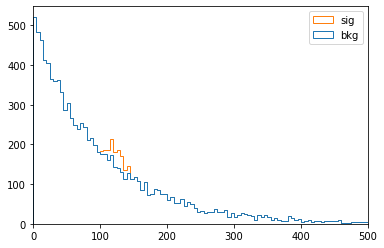

In [173]:
Nbins = 100
myRange = (0,500)
(n,_), edg, _ = plt.hist([b,s],Nbins,myRange,histtype='step',label=['bkg','sig'],stacked=True)
plt.legend()
plt.xlim(myRange)
plt.show()

In [174]:
t = torch.from_numpy(0.5 * (edg[:-1] + edg[1:]))
n = torch.from_numpy(n).float()

Ok, now let's set up the neural ode

### Step 2: Set up a loop to do the training

**Plan:** Similar to the spiral ODEs problem, I'm going to grab points every 20, but not evaluate the loss for the points that should be masked.


In [146]:
batch_size=32
batch_time=20
niters=30
test_freq=20

I want to mask the values between $125 \pm 10$ GeV.

In [213]:
115/5

23.0

In [214]:
edg[23]

115.0

In [218]:
t[22]

tensor(112.5000, dtype=torch.float64)

So the t values that I need to mask are indices 23, 24, 25, and 26.

In [237]:
mask = np.ones_like(n).astype(bool)
mask[23:27] = False

mask = torch.from_numpy(mask)

In [226]:
n

tensor([522., 484., 464., 412., 406., 364., 360., 362., 331., 287., 305., 267.,
        250., 240., 255., 243., 211., 217., 198., 180., 184., 186., 187.,   0.,
          0.,   0.,   0., 136., 145., 114., 117., 108.,  85., 106.,  73.,  76.,
         87.,  84.,  76.,  74.,  59.,  67.,  52.,  52.,  63.,  46.,  55.,  50.,
         40.,  31.,  32.,  27.,  29.,  30.,  37.,  30.,  29.,  35.,  17.,  26.,
         16.,  23.,  26.,  24.,  23.,  19.,  10.,  21.,  18.,  21.,  18.,   9.,
         15.,   9.,   8.,   8.,  19.,  14.,  10.,  11.,   5.,   6.,   9.,   5.,
          6.,   7.,   4.,   6.,   7.,   6.,   6.,  10.,   3.,   2.,   1.,   4.,
          4.,   4.,   4.,   5.])

In [225]:
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [240]:
def get_batch(returnMask=False):
    
    s = torch.from_numpy(np.random.choice(np.arange(len(t) - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = n[s].reshape(batch_size,1)  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([n[s + i] for i in range(batch_time)], dim=0).reshape(batch_time,batch_size,1)  # (T, M, D)
    
    if returnMask:
        batch_mask = torch.stack([mask[s + i] for i in range(batch_time)], dim=0).reshape(batch_time,batch_size,1)  # (T, M, D)
        return batch_y0, batch_t, batch_y, batch_mask

    else:
        return batch_y0, batch_t, batch_y


In [62]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

In [176]:
func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))


Iter 0001 | Total Loss 38.650288
Iter 0002 | Total Loss 23.838306
Iter 0003 | Total Loss 26.340027
Iter 0004 | Total Loss 18.436502
Iter 0005 | Total Loss 13.993103
Iter 0006 | Total Loss 22.386745
Iter 0007 | Total Loss 20.895874
Iter 0008 | Total Loss 13.326136
Iter 0009 | Total Loss 15.740961
Iter 0010 | Total Loss 15.409445
Iter 0011 | Total Loss 16.550198
Iter 0012 | Total Loss 20.260996
Iter 0013 | Total Loss 19.911741
Iter 0014 | Total Loss 14.847058
Iter 0015 | Total Loss 14.656729
Iter 0016 | Total Loss 8.308256
Iter 0017 | Total Loss 16.128300
Iter 0018 | Total Loss 15.351549
Iter 0019 | Total Loss 10.144396
Iter 0020 | Total Loss 14.669629
Iter 0021 | Total Loss 12.484502
Iter 0022 | Total Loss 13.748157
Iter 0023 | Total Loss 9.492365
Iter 0024 | Total Loss 12.046640
Iter 0025 | Total Loss 10.080373
Iter 0026 | Total Loss 13.156627
Iter 0027 | Total Loss 22.149008
Iter 0028 | Total Loss 17.931824
Iter 0029 | Total Loss 13.537618
Iter 0030 | Total Loss 14.070160


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


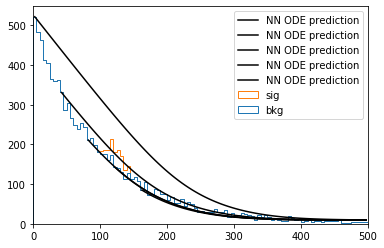

In [197]:
for ti in np.linspace(0,40,5,endpoint=False).astype(int):
    
    pred_y = odeint(func, torch.tensor(n[ti]).reshape(1,1), t[ti:])

    fit = pred_y.detach().numpy().squeeze()
    
    plt.plot(t[ti:].detach().numpy(),fit,'k',label='NN ODE prediction')

Nbins = 100
myRange = (0,500)
plt.hist([b,s],Nbins,myRange,histtype='step',label=['bkg','sig'],stacked=True)
plt.legend()
plt.xlim(myRange)
plt.show()


Ok, so it matters *a lot* what point you start from... **good to know** because I hadn't realized this before.

Ok, so it seems like the prediction is *a lot* better if you're close to where you're trying to predict, so maybe we just want to do the prediction just before we enter the blinded region, since this is where we're going to do the prediction.

**Why do I have to be so close the the region of interest for the prediction to be accurate?**

**Ideas:** 
- Maybe when I start farther to the left, I didn't have as much training data to make an accurate prediction?

**Question:** When I'm fitting a smoothed histogram this way, can I encode the randomness of the problem?

Maybe instead of using a single histogram, I could (for my truth labels) draw from a Poissonian distribution with mean given by the points in the bin?

I'm not sure if this would be legit statistics though!

### Step 3: Train without looking in the blinded region

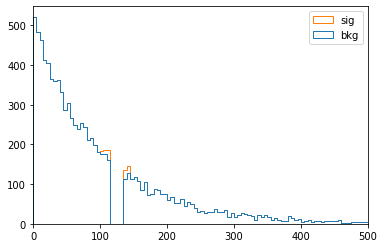

In [223]:
Nbins = 100
myRange = (0,500)
(_,n), edg, _ = plt.hist([b[np.abs(b-125)>10],s[np.abs(s-125)>10]],Nbins, myRange, 
                         histtype='step',label=['bkg','sig'],stacked=True)
plt.legend()
plt.xlim(myRange)
plt.show()

t = torch.from_numpy(0.5 * (edg[:-1] + edg[1:]))
n = torch.from_numpy(n).float()

In [241]:
func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y, batch_mask = get_batch(returnMask=True)
    pred_y = odeint(func, batch_y0, batch_t)

    loss = torch.mean(torch.abs(pred_y[batch_mask] - batch_y[batch_mask]))
    loss.backward()
    optimizer.step()

    print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))


Iter 0001 | Total Loss 25.660553
Iter 0002 | Total Loss 28.661556
Iter 0003 | Total Loss 19.296141
Iter 0004 | Total Loss 22.654951
Iter 0005 | Total Loss 22.953707
Iter 0006 | Total Loss 18.991703
Iter 0007 | Total Loss 17.136337
Iter 0008 | Total Loss 14.951234
Iter 0009 | Total Loss 21.784050
Iter 0010 | Total Loss 18.157032
Iter 0011 | Total Loss 18.951273
Iter 0012 | Total Loss 20.708261
Iter 0013 | Total Loss 22.618279
Iter 0014 | Total Loss 25.888456
Iter 0015 | Total Loss 18.949532
Iter 0016 | Total Loss 17.394526
Iter 0017 | Total Loss 19.420689
Iter 0018 | Total Loss 13.812155
Iter 0019 | Total Loss 15.716043
Iter 0020 | Total Loss 9.308823
Iter 0021 | Total Loss 16.474329
Iter 0022 | Total Loss 8.927383
Iter 0023 | Total Loss 14.699251
Iter 0024 | Total Loss 17.258282
Iter 0025 | Total Loss 16.722681
Iter 0026 | Total Loss 15.740685
Iter 0027 | Total Loss 11.546085
Iter 0028 | Total Loss 17.415453
Iter 0029 | Total Loss 14.417765
Iter 0030 | Total Loss 17.056789


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


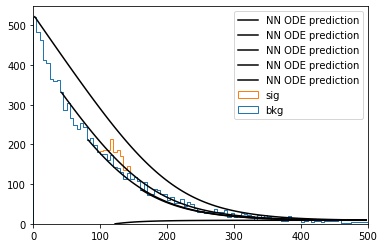

In [242]:
for ti in np.linspace(0,40,5,endpoint=False).astype(int):
    
    pred_y = odeint(func, torch.tensor(n[ti]).reshape(1,1), t[ti:])

    fit = pred_y.detach().numpy().squeeze()
    
    plt.plot(t[ti:].detach().numpy(),fit,'k',label='NN ODE prediction')

Nbins = 100
myRange = (0,500)
plt.hist([b,s],Nbins,myRange,histtype='step',label=['bkg','sig'],stacked=True)
plt.legend()
plt.xlim(myRange)
plt.show()


Ok, this *doesn't look bad*... and actually pretty good!

## Next step

Ok, so this model is really not doing anything different than just fitting a function, so I think what I *want* to try is modelling the distribution of some of other variable, given the variable that we're doig the interpolation over.


So for example, I can take the same exponential distribution that I was using above, but instead of predicting $\exp{t}$, I should predict the distribtion of a Gaussian whose mean and width depend on {t}.

I.e, I'm considering the probabilistic model

$$t \sim \exp(\lambda)$$

$$x \sim \mathcal{N}(\mu(t),\sigma(t))$$
